In [2]:
import torch.nn as nn
import random
import torch
import torchvision
import numpy as np
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, Dataset
from torchsummary import summary
%matplotlib inline

In [3]:
from skimage.io import imread

In [7]:
#data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Train"
#test_data_dir = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Test"
normalize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5), 
                                     std = (0.5, 0.5, 0.5))])

#dataset = ImageFolder(data_dir,transform = normalize_transform)
#test_dataset = ImageFolder(test_data_dir,transform= normalize_transform)

In [8]:
from skimage.io import imread

In [9]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((300,400)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])

#train2 = ImageFolder(data_dir,transform = transforms)

In [10]:
root = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Project"

In [11]:
dataset = ImageFolder(root,transform = normalize_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [12]:
dataset2 = ImageFolder(root,transform = transforms)
train_size2 = int(0.8 * len(dataset2))
test_size2 = len(dataset) - train_size
train_dataset2, test_dataset2 = random_split(dataset, [train_size2, test_size2])

In [13]:
batch_size = 12
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size)

(-0.5, 755.5, 151.5, -0.5)

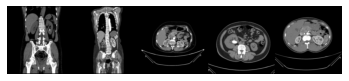

In [13]:
dataiter = iter(train_loader2)
images, labels = dataiter.next()
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:5], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [14]:
classes = []
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 
    classes.extend(y.tolist())

In [15]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [16]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
    
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2),
  
         
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2),
              
           
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
         
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(20736, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10)
        )
  
    def forward(self, x):
        return self.model(x)

In [17]:
def onehot(label, n_classes):
    return torch.zeros(label.size(0), n_classes).scatter_(
        1, label.view(-1, 1), 1)

In [18]:
def mixup(data, targets, alpha, n_classes):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    targets = onehot(targets, n_classes)
    targets2 = onehot(targets2, n_classes)

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets



In [19]:
def cross_entropy_loss(input, target, size_average=True):
    input = F.log_softmax(input, dim=1)
    loss = -torch.sum(input * target)
    if size_average:
        return loss / input.size(0)
    else:
        return loss


class CrossEntropyLoss(object):
    def __init__(self, size_average=True):
        self.size_average = size_average

    def __call__(self, input, target):
        return cross_entropy_loss(input, target, self.size_average)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = CNN().to(device)
model = CNN()

In [21]:
model = model.to(device)

In [22]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             896
              ReLU-2         [-1, 32, 150, 150]               0
         MaxPool2d-3           [-1, 32, 75, 75]               0
            Conv2d-4           [-1, 64, 75, 75]          18,496
              ReLU-5           [-1, 64, 75, 75]               0
         MaxPool2d-6           [-1, 64, 37, 37]               0
            Conv2d-7           [-1, 64, 37, 37]          36,928
              ReLU-8           [-1, 64, 37, 37]               0
         MaxPool2d-9           [-1, 64, 18, 18]               0
          Flatten-10                [-1, 20736]               0
           Linear-11                  [-1, 512]      10,617,344
             ReLU-12                  [-1, 512]               0
           Linear-13                   [-1, 10]           5,130
Total params: 10,678,794
Trainable para

In [23]:
model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=20736, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [24]:

#Defining the model hyper parameters
num_epochs = 30
learning_rate = 0.001
weight_decay = 0.01
weights = torch.Tensor([0.4, 0.6])
criterion = nn.CrossEntropyLoss()
criterion.to(device)
#criterion = torch.nn.BCELoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [25]:
 
#Training process begins for Normal Data
def trainmodel(model, num_epochs, loader, criterion, optimizer):
    train_loss_list = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
        train_loss = 0
      
        #Iterating over the training dataset in batches
        model.train()
        for i, (images, labels) in enumerate(loader):
            #if i > 0 and i%5 == 0:
            #images, labels = mixup(images, labels, 0.2, 2)

          
            #Extracting images and target labels for the batch being iterated
            images = images.to(device)
            labels = labels.to(device)
  
            #Calculating the model output and the cross entropy loss
            outputs = model(images)
            loss = criterion(outputs, labels)
  
            #Updating weights according to calculated loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
      
        #Printing loss for each epoch
        train_loss_list.append(train_loss/len(train_loader))
        print(f"Training loss = {train_loss_list[-1]}")   
      
    #Plotting loss for all epochs
    plt.plot(range(1,num_epochs+1), train_loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")
    return


In [26]:
torch.cuda.empty_cache()

Epoch 1/30: Training loss = 0.22235346070637715
Epoch 2/30: Training loss = 0.0749971486051111
Epoch 3/30: Training loss = 0.04983026501073411
Epoch 4/30: Training loss = 0.02797384284711501
Epoch 5/30: Training loss = 0.019893164642195323
Epoch 6/30: Training loss = 0.013070550799195163
Epoch 7/30: Training loss = 0.011726917442042904
Epoch 8/30: Training loss = 0.02249697597845855
Epoch 9/30: Training loss = 0.0323958558307259
Epoch 10/30: Training loss = 0.01886482503140185
Epoch 11/30: Training loss = 0.006908745436580165
Epoch 12/30: Training loss = 0.017545862632012996
Epoch 13/30: Training loss = 0.012464564339057084
Epoch 14/30: Training loss = 0.00864666624779507
Epoch 15/30: Training loss = 0.022505913683883317
Epoch 16/30: Training loss = 0.009168682261743501
Epoch 17/30: Training loss = 0.0076757937678103546
Epoch 18/30: Training loss = 0.007085210501223225
Epoch 19/30: Training loss = 0.03274462868066389
Epoch 20/30: Training loss = 0.012430326024035168
Epoch 21/30: Traini

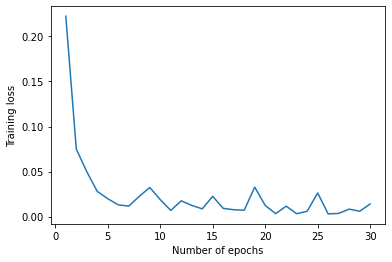

In [30]:
trainmodel(model, num_epochs, train_loader, criterion, optimizer)

In [27]:
def testmodel(model, loader):
    test_acc=0
    model.eval()
  
    with torch.no_grad():
        #Iterating over the training dataset in batches
        for i, (images, labels) in enumerate(loader):
          
            images = images.to(device)
            y_true = labels.to(device)
          
            #Calculating outputs for the batch being iterated
            outputs = model(images)
          
            #Calculated prediction labels from models
            _, y_pred = torch.max(outputs.data, 1)

            #Comparing predicted and true labels
            test_acc += (y_pred == y_true).sum().item()
      
        print(f"Test set accuracy = {100 * test_acc / len(test_dataset)} %")

In [37]:
testmodel(model, test_loader)

Test set accuracy = 100.0 %


Epoch 1/30: Training loss = 0.0033902279172425783
Epoch 2/30: Training loss = 0.003898099142368247
Epoch 3/30: Training loss = 0.01598129260889337
Epoch 4/30: Training loss = 0.02101791525938878
Epoch 5/30: Training loss = 0.0029477119034346222
Epoch 6/30: Training loss = 0.0038393500092176137
Epoch 7/30: Training loss = 0.0035941120756249932
Epoch 8/30: Training loss = 0.02788168025593807
Epoch 9/30: Training loss = 0.002895203329487744
Epoch 10/30: Training loss = 0.0033360598538476377
Epoch 11/30: Training loss = 0.0037519559620130994
Epoch 12/30: Training loss = 0.0037717258889248227
Epoch 13/30: Training loss = 0.054517928616869944
Epoch 14/30: Training loss = 0.005732485736026634
Epoch 15/30: Training loss = 0.0033967488130242822
Epoch 16/30: Training loss = 0.020961878384499016
Epoch 17/30: Training loss = 0.006022301572212937
Epoch 18/30: Training loss = 0.0029123495175560456
Epoch 19/30: Training loss = 0.0032134539478056784
Epoch 20/30: Training loss = 0.0038200943834964607
E

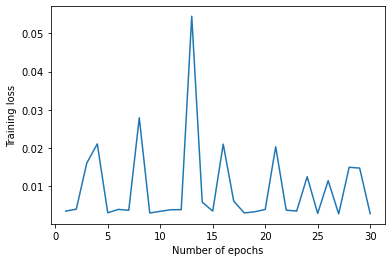

In [36]:
trainmodel(model, num_epochs, train_loader2, criterion, optimizer)

In [39]:
testmodel(model, test_loader2)

Test set accuracy = 100.0 %


In [19]:
torch.save(model.state_dict(), 'nonmixup.pth')

In [28]:
fname = 'D:\\Git\\Research Paper\\Research_Project\\projectCNN.pth'
loaded_dict = torch.load(fname)
model.load_state_dict(loaded_dict)

<All keys matched successfully>

In [21]:
images = images.to(device)
y_true = labels.to(device)
outputs = model(images)
print(outputs)

NameError: name 'images' is not defined

In [29]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [30]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class : Stone


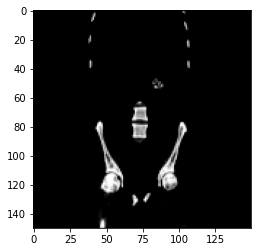

In [31]:
from PIL import Image

#open image file
img_path = "D:\Git\Research Paper\DataSet - Mehedi Hasan, Medical Technologist, Bangladesh Hospitals\Test\Stone\Stone- (1100).jpg"
img = Image.open(img_path)

#convert image to tensor
img = normalize_transform(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [32]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [36]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [33]:
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)


edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)


cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)


(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

In [37]:
for c in cnts:
    	# if the contour is not sufficiently large, ignore it
	if cv2.contourArea(c) < 100:
		continue
	# compute the rotated bounding box of the contour
	orig = image.copy()
	box = cv2.minAreaRect(c)
	box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
	box = np.array(box, dtype="int")
	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
	box = perspective.order_points(box)
	cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
	# loop over the original points and draw them
	for (x, y) in box:
		cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

In [38]:
	(tl, tr, br, bl) = box
	(tltrX, tltrY) = midpoint(tl, tr)
	(blbrX, blbrY) = midpoint(bl, br)
	# compute the midpoint between the top-left and top-right points,
	# followed by the midpoint between the top-righ and bottom-right
	(tlblX, tlblY) = midpoint(tl, bl)
	(trbrX, trbrY) = midpoint(tr, br)
	# draw the midpoints on the image
	cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
	cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
	# draw lines between the midpoints
	cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
		(255, 0, 255), 2)
	cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
		(255, 0, 255), 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [39]:
	dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
	dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
	# if the pixels per metric has not been initialized, then
	# compute it as the ratio of pixels to supplied metric
	# (in this case, inches)
	if pixelsPerMetric is None:
		pixelsPerMetric = dB / 3

In [1]:
	dimA = dA / pixelsPerMetric
	dimB = dB / pixelsPerMetric
	# draw the object sizes on the image
	cv2.putText(orig, "{:.1f}in".format(dimA),
		(int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	cv2.putText(orig, "{:.1f}in".format(dimB),
		(int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2)
	# show the output image
	cv2.imshow("Image", orig)
	cv2.waitKey(0)

NameError: name 'dA' is not defined